# ARIMA

In [1]:
from formulas import *
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

keras = tf.keras

**DATA IMPORTING**

In [2]:
# Read data in to dataframes
nabil = pd.read_csv('../Data/NabilModifiedDate.csv')

# Change date column to datetime type
nabil['Date'] = pd.to_datetime(nabil['Date'])

In [3]:
nabil.tail(100)

,Date,Open,High,Low,Close,Percent Change,Volume
2045,2022-07-27,866.0,870.0,853.0,866.0,0.00,43850
2046,2022-07-28,880.0,880.0,865.0,866.0,0.00,43396
2047,2022-07-29,866.0,880.0,865.0,869.9,0.45,17497
2048,2022-07-31,879.0,882.0,871.0,881.0,1.28,52796
2049,2022-08-01,894.9,897.5,880.0,881.9,0.10,47675
...,...,...,...,...,...,...,...
2140,2022-12-22,809.0,811.0,800.1,810.0,0.37,66052
2141,2022-12-26,811.0,840.0,811.0,838.0,3.46,110057
2142,2022-12-27,847.0,860.0,834.0,842.0,0.48,133855
2143,2022-12-28,845.0,847.0,826.1,834.9,-0.84,105429


In [4]:
nabil.dropna(inplace=True)

### NABIL Train Test Split

Here we can see our complete plot in terms of time steps. Our entire data set is just shy of 2200 time steps. We know that our data is in days, so our data is just shy of 2200 daily observations. We need to separate out a training and validation set to see how our model holds up.

I will be choosing an arbitrary date to separate the training, validation, and test data.

In [5]:
series = nabil['Close']

# CREATE THE TRAIN TEST DATASET
train_split_date = '2019-12-31'
train_split_index = np.where(nabil.Date == train_split_date)[0][0]
x_train = nabil.loc[nabil['Date'] <= train_split_date]['Close']

# CREATE THE TEST DATASET
test_split_date = '2021-01-03'
test_split_index = np.where(nabil.Date == test_split_date)[0][0]
x_test = nabil.loc[nabil['Date'] >= test_split_date]['Close']

# CREATE THE VALIDATION DATASET
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = nabil.loc[(nabil['Date'] < test_split_date) & (nabil['Date'] > train_split_date)]['Close']

1479 1480 1663 1664 2144


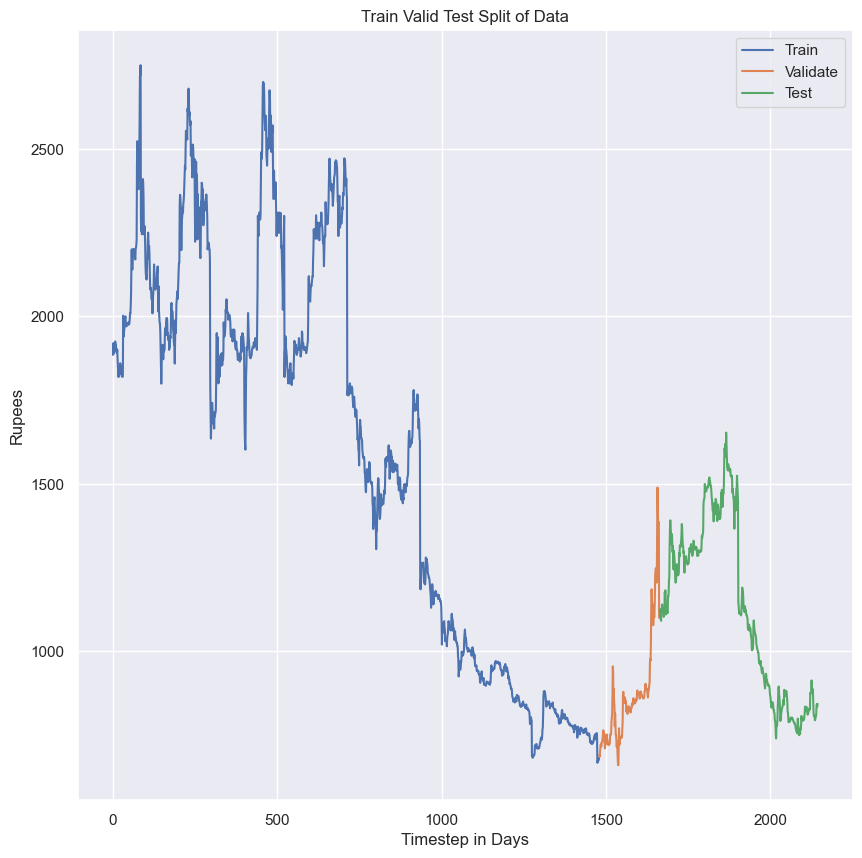

In [6]:
# SET STYLE OF CHARTS
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.title('Train Valid Test Split of Data')
plt.ylabel('Rupees')
plt.xlabel('Timestep in Days')
plt.legend()
plt.savefig('../Images/ARIMA/ARIMA TRAIN TEST SPLIT')
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

# ARIMA


**First we need to see if the data is stationary**

I have used Augmented Dickey Fuller test to determine if the data is stationary.
- Failure to reject the null hypothesis means the data is not stationary

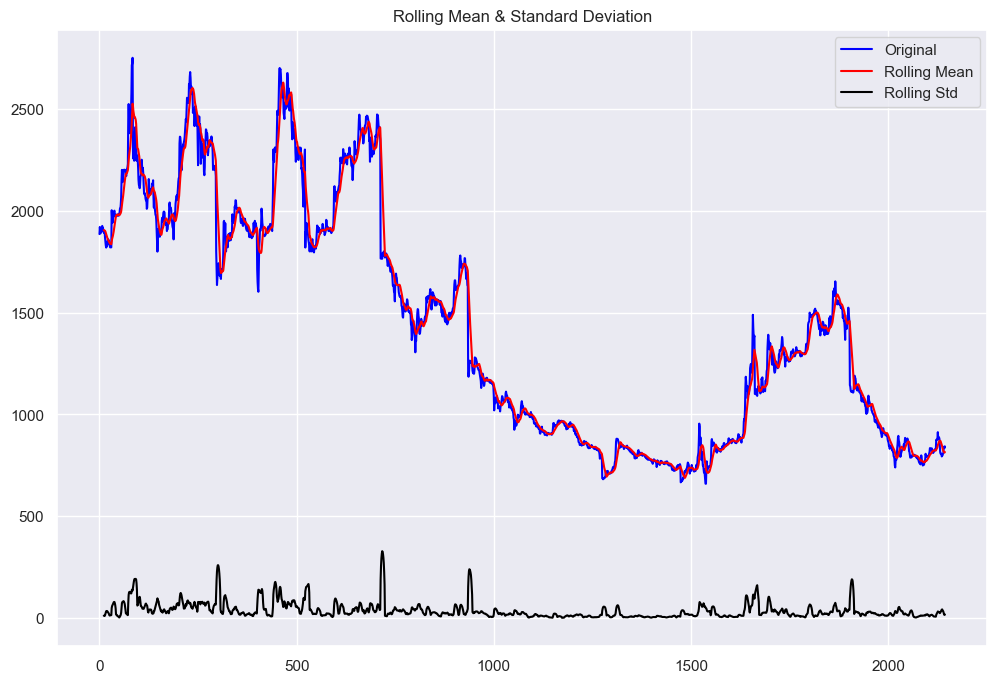

Results of Dickey-Fuller Test:
p-value = 0.5766. The series is likely non-stationary.
Test Statistic                   -1.411910
p-value                           0.576553
#Lags Used                        4.000000
Number of Observations Used    2140.000000
Critical Value (1%)              -3.433409
Critical Value (5%)              -2.862892
Critical Value (10%)             -2.567489
dtype: float64


<Figure size 1000x1000 with 0 Axes>

In [7]:
test_stationarity(series)
plt.savefig('../Images/ARIMA/ARIMA ROLLING MEAN AND STANDARD DEVIATION')

The **p-value is obtained is greater than significance level of 0.05** and the **ADF statistic is higher than any of the critical values.**

Clearly, there is no reason to reject the null hypothesis. **So, the time series is in fact non-stationary.** Since our data is not stationary, we need to convert it before modelling.

### Step 2 Differencing
We must convert our non-stationary data to stationary data using the differencing method. This means we take the value at time (t) and subtract the value at time (t-1) to get the difference. This difference is also the calculated return over that period. Since our time steps are in days this differencing is the daily return.

In [8]:
# Get the difference of each Close point
nabil_close_diff_1 = series.diff()
nabil_close_diff_1.dropna(inplace=True)

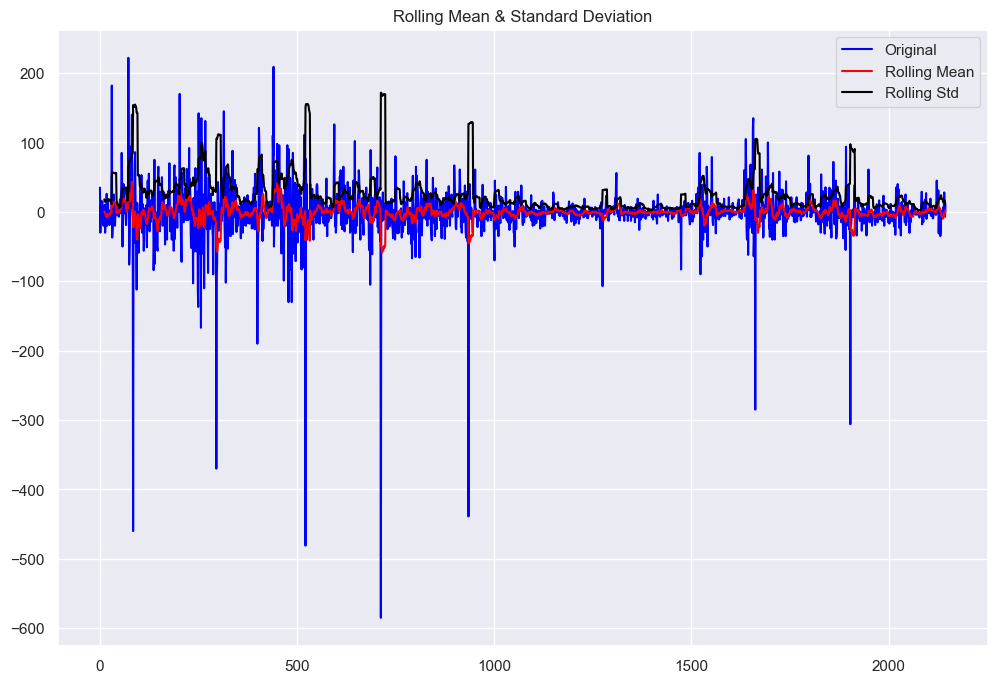

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                  -24.823159
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    2140.000000
Critical Value (1%)              -3.433409
Critical Value (5%)              -2.862892
Critical Value (10%)             -2.567489
dtype: float64


<Figure size 1000x1000 with 0 Axes>

In [9]:
# Plot the nabil Close 1st order difference
test_stationarity(nabil_close_diff_1)
plt.savefig('../Images/ARIMA/ARIMA ROLLING MEAN AND STANDARD DEVIATION CLOSE')

The **p-value is obtained is less than significance level of 0.05** and the **ADF statistic is lower than any of the critical values.**

We reject the null hypothesis. **So, the time series is in fact stationary.** 

### Step 3: Autocorrelation and Partial autocorrelation

Autocorrelation and partial autocorrelation plots are heavily used in time series analysis and forecasting.

These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps. The difference between autocorrelation and partial autocorrelation can be difficult and confusing for beginners to time series forecasting.

Autocorrelation is the correlation between points at time t (Pₜ) and the point at(Pₜ₋₁). Partial autocorrelation is the point at time t (Pₜ) and the point (Pₜ₋ₖ) where k is any number of lags. Partial autocorrelation ignores all of the data in between both points.

In terms of a movie theater’s ticket sales, autocorrelation determines the relationship of today’s ticket sales and yesterday’s ticket sales. In comparison, partial autocorrelation defines the relationship of this Friday’s ticket sales and last Friday’s ticket sales.

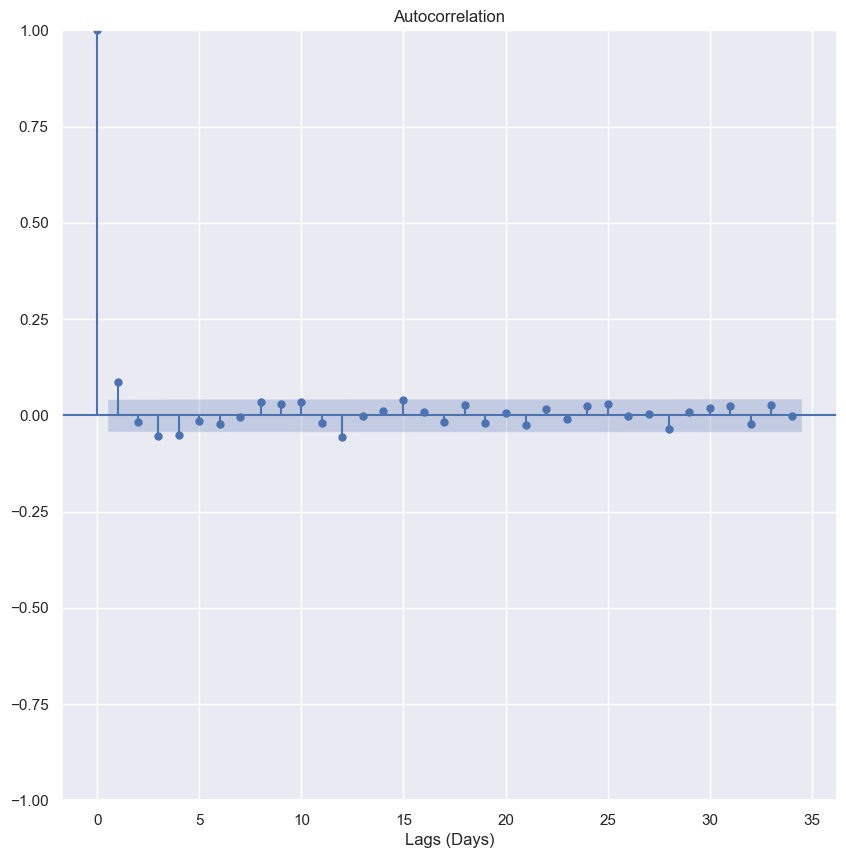

In [10]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(nabil_close_diff_1)
plt.xlabel('Lags (Days)')
plt.savefig('../Images/ARIMA/ARIMA AUTOCORRELATION')
plt.show()

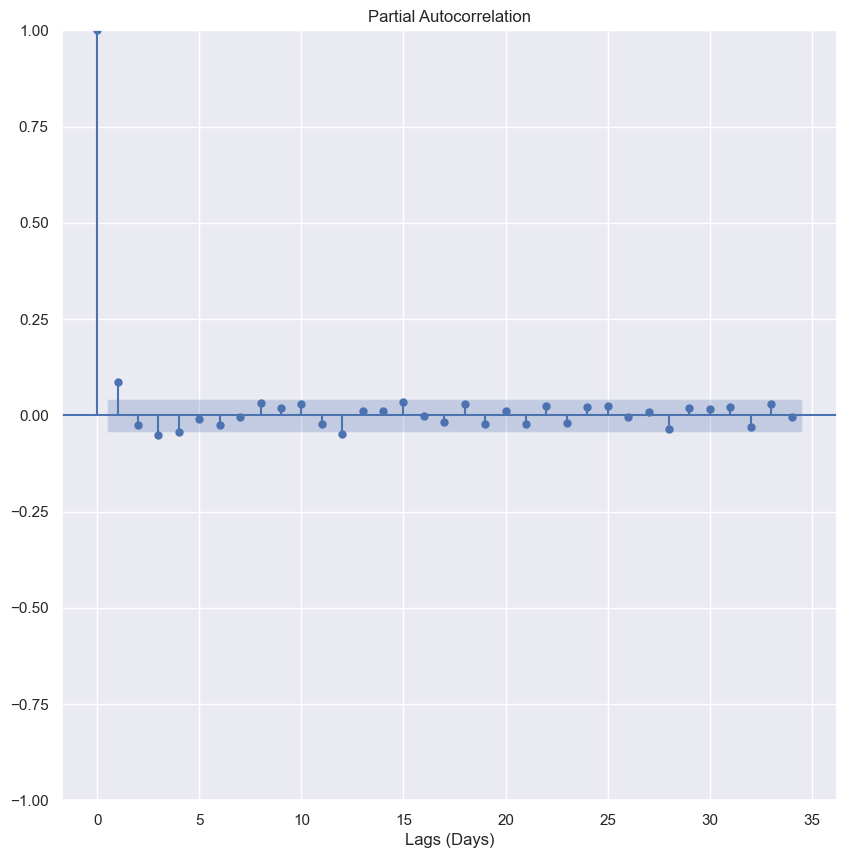

In [11]:
plot_pacf(nabil_close_diff_1)
plt.xlabel('Lags (Days)')
plt.savefig('../Images/ARIMA/ARIMA PARTIAL AUTOCORRELATION')
plt.show()

- These plots look almost identical, but they’re not. Let’s start with the Autocorrelation plot. The important detail of these plots is the first lag. If the first lag is positive, we use an autoregressive (AR) model, and if the first lag is negative, we use a moving average (MA) plot. Since the first lag is negative, and the 2nd lag is positive, we will use the 1st lag as a moving average point.
<br/><br/>
- For the PACF plot, since there is a substantial dropoff at lag one, which is negatively correlated, we will use an AR factor of 1 as well. If you have trouble determining how what lags are the best to use, feel free to experiment, and watch the AIC. The lower the AIC, the better.
<br/><br/>
- The ARIMA model takes three main inputs into the “order” argument. Those arguments are ‘p’ for the AR term, ‘d’ for the differencing term, ‘q’ for the MA term. We have determined the best model for our data is of order (1,1,1). Once again, feel free to change these numbers and print out the summary of the models to see which variation has the lowest AIC. The training time is relatively quick.

### Testing different arima models

In [12]:
from statsmodels.tsa.arima.model import ARIMA

# fit model
nabil_arima = ARIMA(x_train, order=(4,2,0))
nabil_arima_fit = nabil_arima.fit()
print(nabil_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1480
Model:                 ARIMA(4, 2, 0)   Log Likelihood               -7738.862
Date:                Wed, 10 May 2023   AIC                          15487.724
Time:                        21:13:45   BIC                          15514.216
Sample:                             0   HQIC                         15497.600
                               - 1480                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6905      0.011    -62.701      0.000      -0.712      -0.669
ar.L2         -0.5049      0.016    -31.603      0.000      -0.536      -0.474
ar.L3         -0.3803      0.017    -22.578      0.0

NormaltestResult(statistic=2498.1920048855563, pvalue=0.0)
This distribution is not a normal distribution


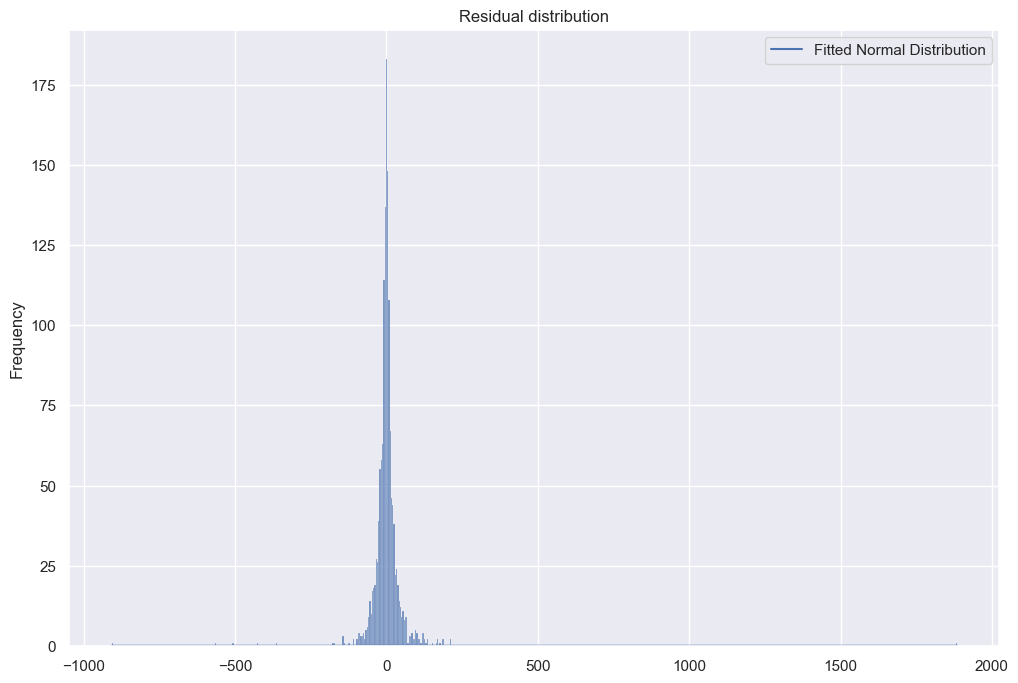

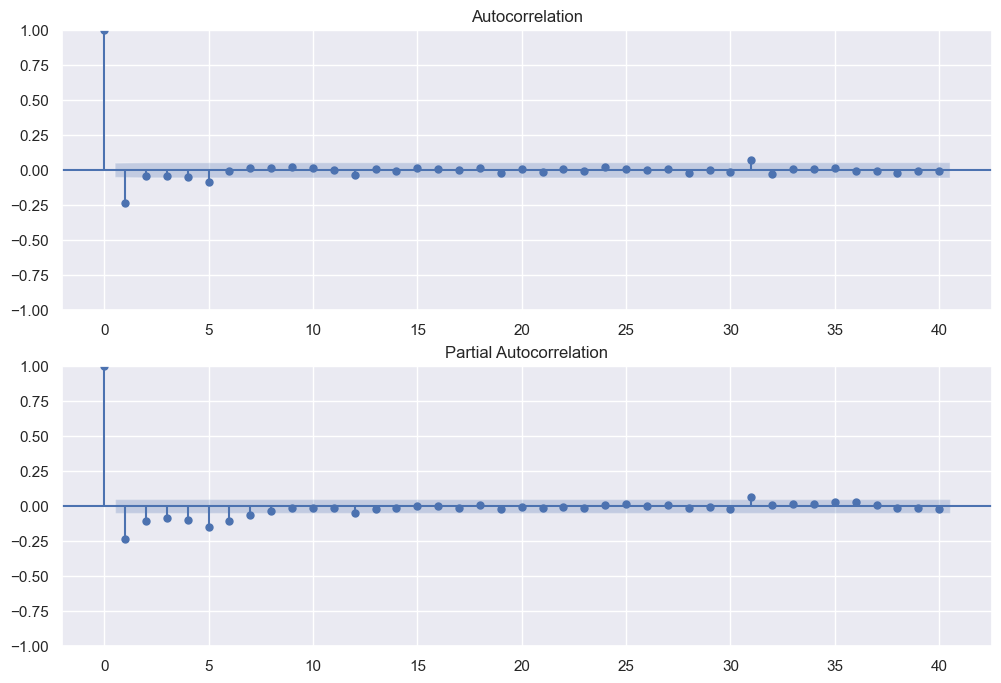

In [13]:
from scipy import stats
import statsmodels.api as sm
from scipy.stats import normaltest
import seaborn as sns
import matplotlib.pyplot as plt

residuals = nabil_arima_fit.resid
print(normaltest(residuals))
if normaltest(residuals)[1] < .05:
    print('This distribution is not a normal distribution')
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig, ax0 = plt.subplots(figsize=(12, 8))

sns.histplot(residuals, ax=ax0)  # Using histplot for histogram

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(residuals)

# Plot the normal distribution curve
x = np.linspace(min(residuals), max(residuals), 100)
y = stats.norm.pdf(x, mu, sigma)
plt.plot(x, y, label='Fitted Normal Distribution')

plt.legend()
plt.ylabel('Frequency')
plt.title('Residual distribution')
plt.savefig('../Images/ARIMA/ARIMA RESIDUAL DISTRIBUTION')

# ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)
plt.show()


### Step 4: Building the Arima Model and Forecasting
Now that we have experimented and found our prefered model order of (4,2,0) lets build the model and get some forecasts.

This cell takes a while to run. Be careful. We have stored the model predictions using a magic method so we do not have to re-run this time consuming cell everytime.

In [14]:
# Create list of x_train values
history = [x for x in x_train]

# Establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

# loop through every data point
for time_point in list(x_test.index[-30:]):
    model = ARIMA(history, order=(4, 2, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)

# Duplicate the last value of model_predictions to extend its length
extended_model_predictions = np.repeat(model_predictions[-1], len(x_test))


# Calculate the mean absolute error for the last 30 data points
MAE_error = keras.metrics.mean_absolute_error(x_test[-30:], model_predictions).numpy()
print('Testing Mean Absolute Error is {}'.format(MAE_error))

%store model_predictions

Testing Mean Absolute Error is 20.006149877560016
Stored 'model_predictions' (list)


/var/folders/7c/1rzbrtxj2s3bn1b6l1dklf8w0000gn/T/ipykernel_8687/2130574793.py:25: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  MAE_error = keras.metrics.mean_absolute_error(x_test[-30:], model_predictions).numpy()


In [15]:
output

array([839.04977111])

In [16]:
# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

[684.2638516678695,
 857.8045806066768,
 844.2584788205905,
 838.4362028975478,
 850.9348528560786]

In [17]:
model_predictions

[684.2638516678695,
 857.8045806066768,
 844.2584788205905,
 838.4362028975478,
 850.9348528560786,
 863.5376137234417,
 825.6871490774021,
 833.866620964561,
 892.6412047702419,
 882.3061305639277,
 883.062795195103,
 891.794967395074,
 934.2825091048873,
 878.770598843424,
 882.8701970995239,
 891.4709510759388,
 882.7975337780223,
 827.3400131999196,
 799.0175699399122,
 794.6991873417028,
 796.2340292695952,
 789.196201418125,
 781.8089031730341,
 793.8310936142962,
 799.8655836579635,
 807.7092440073295,
 810.6653090207288,
 849.222101524482,
 850.5198058141591,
 839.049771113675]

In [18]:
#save model
model_fit.save('../Models/ARIMA.pkl')

# Load model
from statsmodels.tsa.arima.model import ARIMAResults
loaded = ARIMAResults.load('../Models/ARIMA.pkl')

In [19]:
model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = keras.metrics.mean_absolute_error(x_test[-30:], model_predictions).numpy()
print(arima_mae)

20.006149877560016


/var/folders/7c/1rzbrtxj2s3bn1b6l1dklf8w0000gn/T/ipykernel_8687/3238444233.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  arima_mae = keras.metrics.mean_absolute_error(x_test[-30:], model_predictions).numpy()


- You may want to zoom in on the plot below to get a better view of the differences. To do this simply use the [:] slicing on x_test.index and model_predictions/x_test in the plt.plot() lines. I typically like to do [-100:] to get the last 100 values

/var/folders/7c/1rzbrtxj2s3bn1b6l1dklf8w0000gn/T/ipykernel_8687/1866931342.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(x_test.index[-30:], x_test[-30:], color='red', label='ACTUAL')


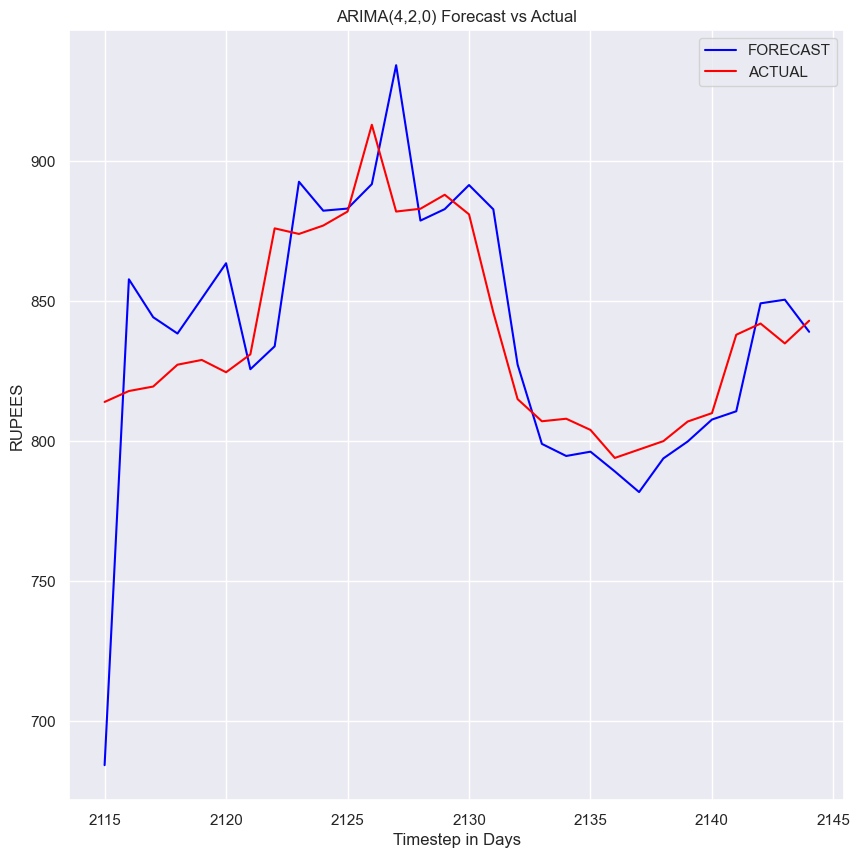

<Figure size 1000x600 with 0 Axes>

MAE ERROR FOR ARIMA MODEL IS: 2115   -129.736148
2116     39.904581
2117     24.758479
2118     11.136203
2119     21.934853
2120     38.937614
2121     -5.312851
2122    -42.133379
2123     18.641205
2124      5.306131
2125      1.062795
2126    -21.205033
2127     52.282509
2128     -4.229401
2129     -5.129803
2130     10.470951
2131     36.797534
2132     12.340013
2133     -8.082430
2134    -13.300813
2135     -7.765971
2136     -4.803799
2137    -15.191097
2138     -6.168906
2139     -7.134416
2140     -2.290756
2141    -27.334691
2142      7.222102
2143     15.619806
2144     -3.950229
Name: Close, dtype: float64


/var/folders/7c/1rzbrtxj2s3bn1b6l1dklf8w0000gn/T/ipykernel_8687/1866931342.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  arima_error = model_predictions - x_test[-30:]


In [20]:
# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-30:], model_predictions[-30:], color='blue', label='FORECAST')
plt.plot(x_test.index[-30:], x_test[-30:], color='red', label='ACTUAL')
plt.ylabel('RUPEES')
plt.xlabel('Timestep in Days')
plt.title('ARIMA(4,2,0) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10, 6))
plt.savefig('../Images/ARIMA/ARIMA FORECAST VS ACTUAL')
plt.show()
arima_error = model_predictions - x_test[-30:]
print(f"MAE ERROR FOR ARIMA MODEL IS: {arima_error}")


#### Show Error in model vs actual

In [21]:
# Find the error in the ARIMA Model by comparing last 30 predictions with last 30 data points
arima_error = model_predictions - x_test[-30:]
print(arima_error)

2115   -129.736148
2116     39.904581
2117     24.758479
2118     11.136203
2119     21.934853
2120     38.937614
2121     -5.312851
2122    -42.133379
2123     18.641205
2124      5.306131
2125      1.062795
2126    -21.205033
2127     52.282509
2128     -4.229401
2129     -5.129803
2130     10.470951
2131     36.797534
2132     12.340013
2133     -8.082430
2134    -13.300813
2135     -7.765971
2136     -4.803799
2137    -15.191097
2138     -6.168906
2139     -7.134416
2140     -2.290756
2141    -27.334691
2142      7.222102
2143     15.619806
2144     -3.950229
Name: Close, dtype: float64


/var/folders/7c/1rzbrtxj2s3bn1b6l1dklf8w0000gn/T/ipykernel_8687/4064021092.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  arima_error = model_predictions - x_test[-30:]


/var/folders/7c/1rzbrtxj2s3bn1b6l1dklf8w0000gn/T/ipykernel_8687/1987561745.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(x_test[-30:].index, arima_error, color='blue', label='Error of Predictions')
/var/folders/7c/1rzbrtxj2s3bn1b6l1dklf8w0000gn/T/ipykernel_8687/1987561745.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.hlines(np.mean(arima_error), xmin=x_test[-30:].index.min(), xmax=x_test[-30:].index.max(), color='red', label='Mean Error')


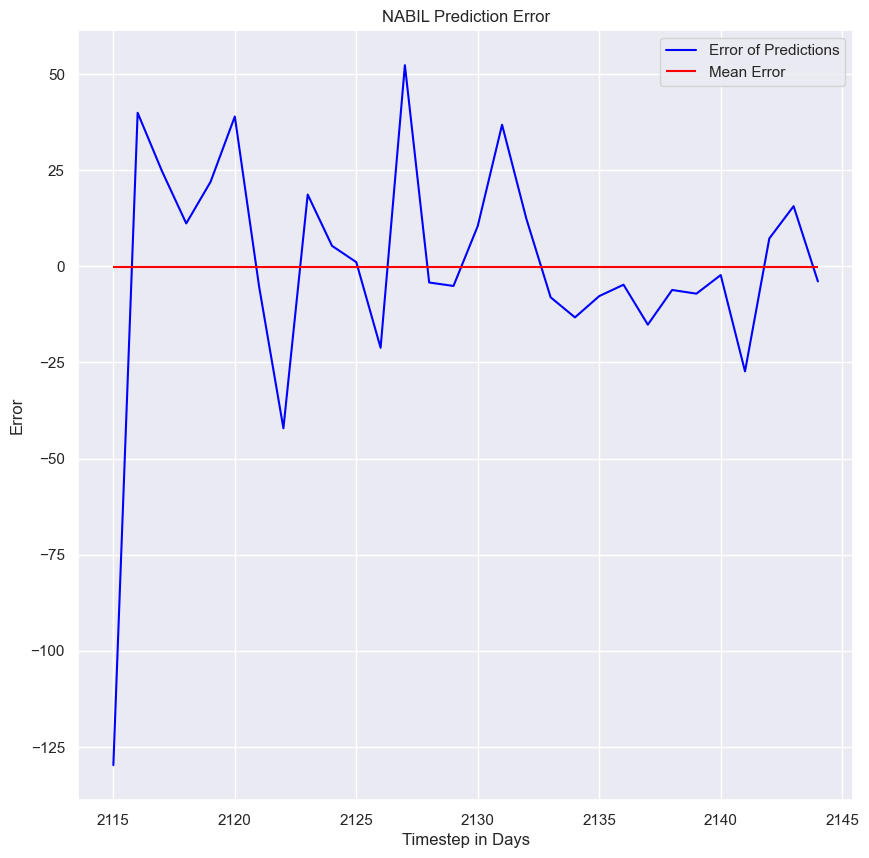

<Figure size 1000x600 with 0 Axes>

In [22]:
plt.plot(x_test[-30:].index, arima_error, color='blue', label='Error of Predictions')
plt.hlines(np.mean(arima_error), xmin=x_test[-30:].index.min(), xmax=x_test[-30:].index.max(), color='red', label='Mean Error')
plt.title('NABIL Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10, 6))
plt.savefig('../Images/ARIMA/ARIMA PREDICTION MAE PLOT')
plt.show()